[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/dbsn-import/blob/main/townhalls_dbsn.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/dbsn-import/blob/main/townhalls_dbsn.ipynb)

# Finding missing town halls in Italy

### Configuration

In [125]:
search_area_id = 3600365331 # Italia
#search_area_id = 3600042611 # Emilia-Romagna
# ID calculated with https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_element_id

In [227]:
province_json_file_path = f"./provinces_{search_area_id}.4326.geojson"
municipality_json_file_path = f"./municipalities_{search_area_id}.4326.geojson"
townhall_json_file_path = f"./townhalls_{search_area_id}.4326.geojson"
without_townhall_json_file_path = f"./without_townhall_{search_area_id}.4326.geojson"
dbsn_json_file_path = f"./dbsn_municipi.geojson"
dbsn_conflict_file_path = f"./dbsn_conflicts_{search_area_id}.4326.geojson"
dbsn_missing_file_path = f"./dbsn_missing_{search_area_id}.4326.geojson"
untagged_json_file_path = f"./untagged_{search_area_id}.4326.geojson"
untagged_missing_json_file_path = f"./untagged_missing_{search_area_id}.4326.geojson"

### Setup

In [127]:
#%pip install geopandas contextily pyproj rtree shapely

In [210]:
from pandas import merge
from geopandas import GeoDataFrame, read_file, points_from_xy
from shapely.geometry import shape, Point, MultiPolygon, LineString
from shapely.ops import polygonize
from urllib.request import urlopen, urlretrieve
from urllib.error import HTTPError
from urllib.parse import quote_plus
from os.path import exists
import contextily as cx
import json
from numpy import array
from os import system

### Download municipalities and existing town halls from Overpass

In [129]:
province_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="6"]["ISO3166-2"!="FR-74"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [130]:
municipality_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="8"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [131]:
townhall_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
nwr["amenity"="townhall"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [132]:
def fetchOverpassGeoDataFrame(overpass_query, geometry_transform=shape):
    url = "https://overpass-api.de/api/interpreter?data="+quote_plus(overpass_query)
    try:
        with urlopen(url) as response:
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            json_content = data.decode(encoding)
        if "Query timed out" in json_content:
            raise Exception("Query timed out")
        #print(json_content)
        json_object = json.loads(json_content)
        #print(json_object['elements'][0] if json_object['elements'] else "No elments")
        elements = [{
            "id": element["id"],
            "osm_id": element["tags"]["_osm_id"],
            "osm_type": element["tags"]["_osm_type"],
            "osm_url": 'https://www.openstreetmap.org/'+element["tags"]["_osm_type"]+'/'+element["tags"]["_osm_id"],
            "name": element["tags"]["name"] if "name" in element["tags"] else None,
            "geometry": geometry_transform(element['geometry'])
        } for element in json_object['elements']]
        #print(elements[0])
        # OSM uses WGS 84: https://wiki.openstreetmap.org/wiki/Converting_to_WGS84
        crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
        gdf = GeoDataFrame(elements, crs=crs)
    except HTTPError as err:
        print("Failed downloading data from Overpass, retry later")
        raise err
    except json.JSONDecodeError as err:
        print("Failed interpreting JSON data from Overpass")
        raise err
    return gdf

In [133]:
def readOrFetchOverpassGeoDataFrame(file_path, overpass_query, geometry_transform=shape):
    if exists(file_path):
        gdf = read_file(file_path, driver='GeoJSON')
    else:
        gdf = fetchOverpassGeoDataFrame(overpass_query, geometry_transform)
        gdf.to_file(file_path, driver='GeoJSON')
    return gdf

In [134]:
# Convert Overpass geometries into MultiPolygons - https://stackoverflow.com/a/72677231/2347196
convert_geom_to_multipolygon = lambda x: MultiPolygon(polygonize(shape(x)))

In [135]:
province_gdf = readOrFetchOverpassGeoDataFrame(province_json_file_path, province_overpass_query, convert_geom_to_multipolygon)
province_gdf.count()

id          109
osm_id      109
osm_type    109
osm_url     109
name        109
geometry    109
dtype: int64

In [136]:
province_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39151,relation,https://www.openstreetmap.org/relation/39151,Agrigento,"MULTIPOLYGON (((13.98219 37.19312, 13.98220 37..."
1,2,39979,relation,https://www.openstreetmap.org/relation/39979,Nuoro,"MULTIPOLYGON (((9.62535 40.25649, 9.62514 40.2..."
2,3,40021,relation,https://www.openstreetmap.org/relation/40021,Aristanis/Oristano,"MULTIPOLYGON (((8.38245 40.33860, 8.38324 40.3..."
3,4,276369,relation,https://www.openstreetmap.org/relation/276369,Cagliari,"MULTIPOLYGON (((9.16386 39.83254, 9.16450 39.8..."
4,5,12998776,relation,https://www.openstreetmap.org/relation/12998776,Sulcis Iglesiente,"MULTIPOLYGON (((8.37422 39.02318, 8.37403 39.0..."


In [137]:
municipality_gdf = readOrFetchOverpassGeoDataFrame(municipality_json_file_path, municipality_overpass_query, convert_geom_to_multipolygon)
municipality_gdf.count()

id          7903
osm_id      7903
osm_type    7903
osm_url     7903
name        7903
geometry    7903
dtype: int64

In [138]:
municipality_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39150,relation,https://www.openstreetmap.org/relation/39150,Lampedusa e Linosa,"MULTIPOLYGON (((12.87805 35.85517, 12.87809 35..."
1,2,39777,relation,https://www.openstreetmap.org/relation/39777,Santu Antiogu/Sant'Antioco,"MULTIPOLYGON (((8.38404 39.00591, 8.38379 39.0..."
2,3,39809,relation,https://www.openstreetmap.org/relation/39809,Câdesédda/Calasetta,"MULTIPOLYGON (((8.37490 39.10915, 8.37532 39.1..."
3,4,39853,relation,https://www.openstreetmap.org/relation/39853,Igrèsias/Iglesias,"MULTIPOLYGON (((8.43347 39.30784, 8.43347 39.3..."
4,5,39915,relation,https://www.openstreetmap.org/relation/39915,Bugerru/Buggerru,"MULTIPOLYGON (((8.41075 39.44130, 8.41059 39.4..."


In [139]:
townhall_gdf = readOrFetchOverpassGeoDataFrame(townhall_json_file_path, townhall_overpass_query)
townhall_gdf.count()

id          7213
osm_id      7213
osm_type    7213
osm_url     7213
name        5634
geometry    7213
dtype: int64

In [140]:
townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,4492704609,node,https://www.openstreetmap.org/node/4492704609,Comune di Carloforte,POINT (8.30562 39.14578)
1,2,2440099045,node,https://www.openstreetmap.org/node/2440099045,None,POINT (8.37907 39.20365)
2,3,1853454108,node,https://www.openstreetmap.org/node/1853454108,Comune di Teulada,POINT (8.77381 38.96790)
3,4,5358907076,node,https://www.openstreetmap.org/node/5358907076,Comune di Sant'Antioco,POINT (8.45543 39.06645)
4,5,2126087185,node,https://www.openstreetmap.org/node/2126087185,Comune di San Giovanni Suergiu,POINT (8.52207 39.11028)


In [141]:
from matplotlib import pyplot as plt
def show_map(geo_df:GeoDataFrame, background_gdf:GeoDataFrame=None, color_column:str=None, cmap:str=None):
    df_wm = geo_df.to_crs(epsg=3857)
    figsize=(20,10)
    fig,ax = plt.subplots(1, 1, figsize=figsize)
    legend = False
    
    if background_gdf is not None:
        background_df_wm = background_gdf.to_crs(epsg=3857)
        ax = background_df_wm.plot(ax=ax, figsize=figsize, alpha=0.3, edgecolor='k')
    
    if color_column is not None:
        legend = True
    
    ax = df_wm.plot(ax=ax, figsize=figsize, edgecolor='k', column=color_column, cmap=cmap, legend=legend)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

Map of municipalities available on OSM:

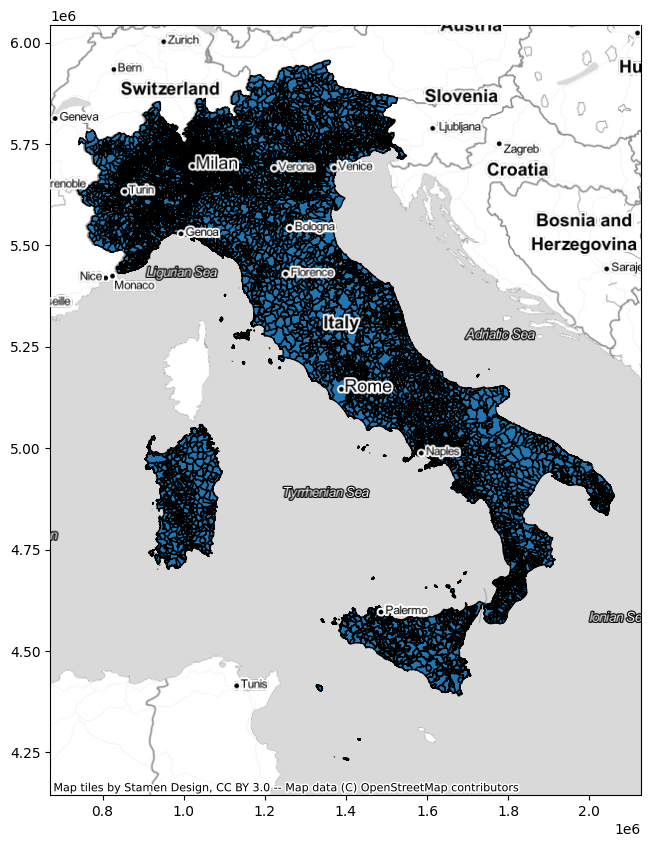

In [142]:
show_map(municipality_gdf)

Map of town halls available on OSM:

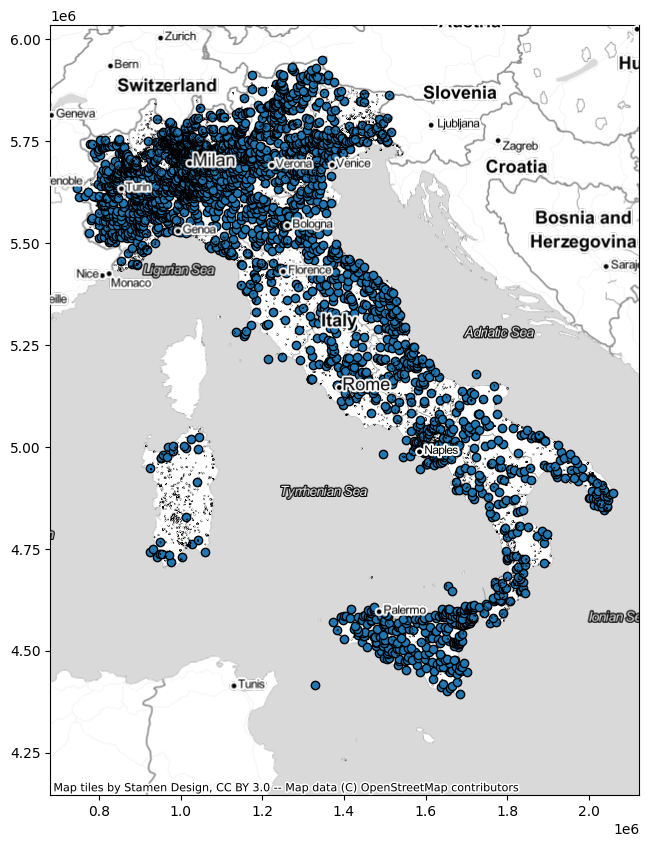

In [143]:
show_map(townhall_gdf)
#show_map(townhall_gdf, municipality_gdf)
#municipality_gdf.explore()
#townhall_gdf.explore()

### Find municipalities without town halls

In [144]:
with_townhall_gdf = townhall_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
with_townhall_gdf.count()

id_hall          7219
osm_id_hall      7219
osm_type_hall    7219
osm_url_hall     7219
name_hall        5639
geometry         7219
index_town       7219
id_town          7219
osm_id_town      7219
osm_type_town    7219
osm_url_town     7219
name_town        7219
dtype: int64

In [145]:
without_townhall_gdf = municipality_gdf[ # Anti-join
        ~municipality_gdf["id"].isin(with_townhall_gdf["id_town"])
    ]
without_townhall_gdf.to_file(without_townhall_json_file_path, driver="GeoJSON")
without_townhall_gdf.count()

id          1319
osm_id      1319
osm_type    1319
osm_url     1319
name        1319
geometry    1319
dtype: int64

In [146]:
without_townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
27,28,39855,relation,https://www.openstreetmap.org/relation/39855,Bidda Matzràxia/Villamassargia,"MULTIPOLYGON (((8.73100 39.28096, 8.73147 39.2..."
44,45,39803,relation,https://www.openstreetmap.org/relation/39803,Sa Baronia/Villaperuccio,"MULTIPOLYGON (((8.61680 39.12812, 8.61717 39.1..."
185,186,12338682,relation,https://www.openstreetmap.org/relation/12338682,Misiliscemi,"MULTIPOLYGON (((12.49852 37.96577, 12.50396 37..."
426,427,40827,relation,https://www.openstreetmap.org/relation/40827,Caragnani/Calangianus,"MULTIPOLYGON (((9.30121 40.84693, 9.30056 40.8..."
453,454,40950,relation,https://www.openstreetmap.org/relation/40950,Sant'Antoni di Gaddura/Sant'Antonio di Gallura,"MULTIPOLYGON (((9.31750 40.92267, 9.31720 40.9..."


Map of municipalities without town hall:

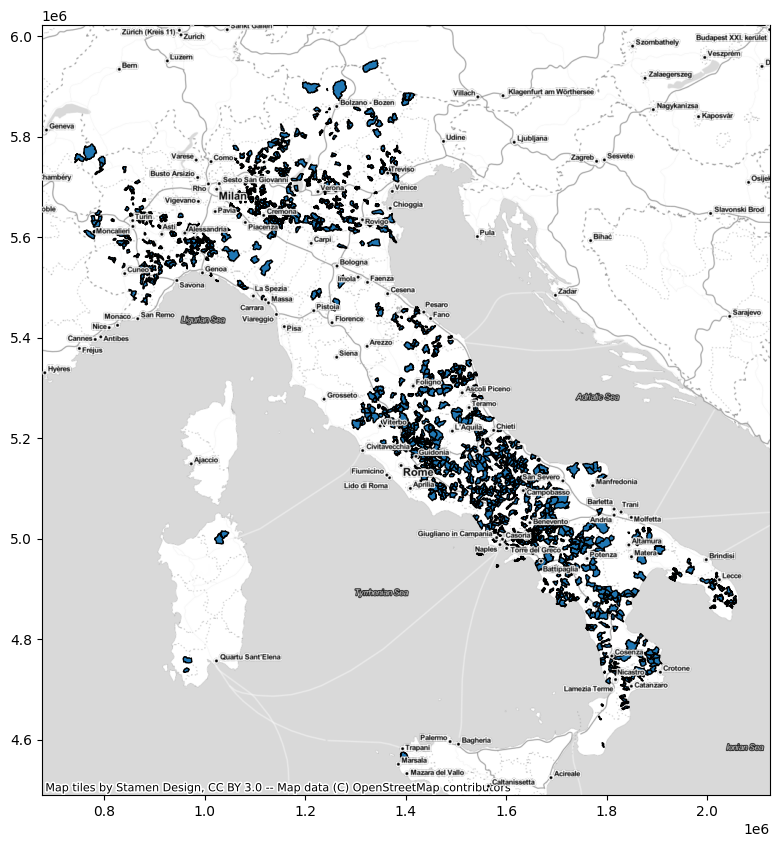

In [147]:
show_map(without_townhall_gdf)
#without_townhall_gdf.explore()

### Calculate statistics for each province

In [148]:
province_municipality_df = province_gdf[["id","geometry"]].sjoin(
        municipality_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_municipalities"] = province_municipality_df.groupby(province_municipality_df.index).count()["index_mun"]

In [149]:
province_without_townhall_df = province_gdf[["id","geometry"]].sjoin(
        without_townhall_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_without_townhall"] = province_without_townhall_df.groupby(province_without_townhall_df.index).count()["index_mun"]

<AxesSubplot: >

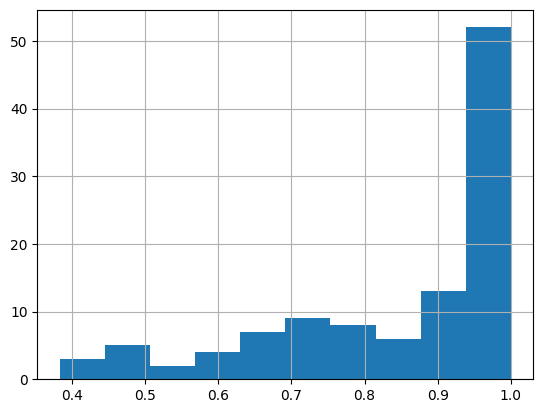

In [150]:
province_gdf["osm_availability"] = 1 - (province_gdf["num_without_townhall"] / province_gdf["num_municipalities"])
province_gdf["osm_availability"].hist()

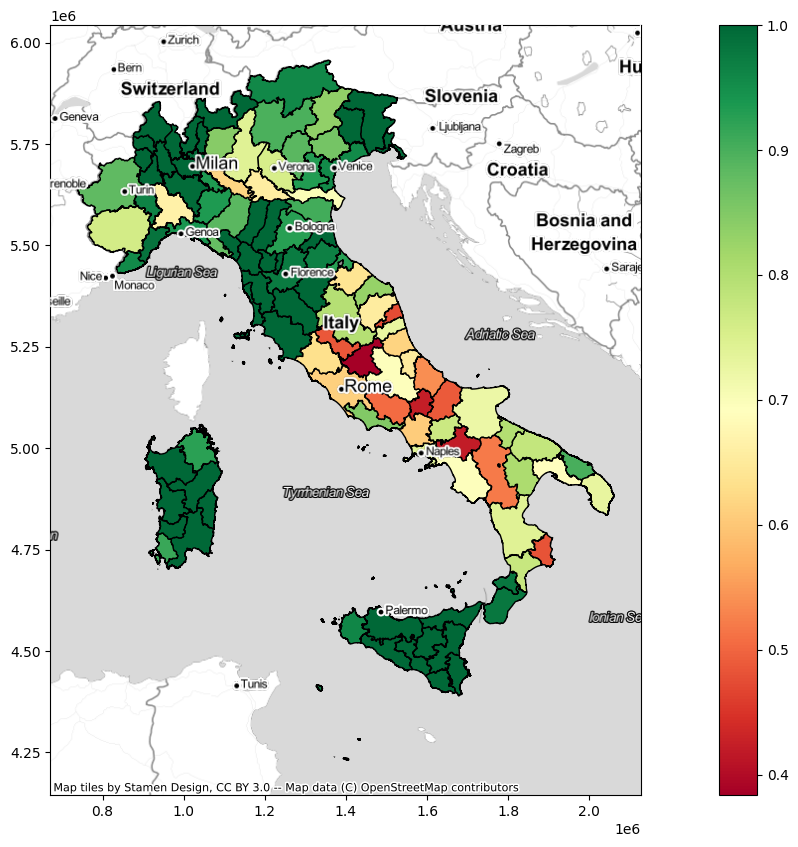

In [151]:
show_map(province_gdf, None, "osm_availability", "RdYlGn")

### Find OSM untagged building named as town halls

In [152]:
untagged_overpass_query=f"""
[out:json][timeout:300];
area({search_area_id})->.searchArea;
nwr["building"]["amenity"!="townhall"]["name"~"^(\s|palazzo|del|nuovo|comune|-)*municipio",i](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [153]:
untagged_gdf = readOrFetchOverpassGeoDataFrame(untagged_json_file_path, untagged_overpass_query)
untagged_gdf.count()

id          30
osm_id      30
osm_type    30
osm_url     30
name        30
geometry    30
dtype: int64

In [154]:
untagged_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,277834707,way,https://www.openstreetmap.org/way/277834707,Municipio di Monserrato,"LINESTRING (9.14363 39.25416, 9.14336 39.25394..."
1,2,933053288,way,https://www.openstreetmap.org/way/933053288,Municipio,"LINESTRING (13.09184 37.95253, 13.09212 37.952..."
2,3,332108931,way,https://www.openstreetmap.org/way/332108931,Municipio Roma V - Aula consigliare,"LINESTRING (12.54262 41.88052, 12.54278 41.880..."
3,4,60145522,way,https://www.openstreetmap.org/way/60145522,Municipio,"LINESTRING (12.95500 41.58178, 12.95523 41.581..."
4,5,42089778,way,https://www.openstreetmap.org/way/42089778,Municipio Frosinone,"LINESTRING (13.35066 41.63963, 13.35074 41.639..."


In [155]:
untagged_missing_gdf = untagged_gdf.sjoin(
        without_townhall_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
untagged_missing_gdf.count()

id_hall          1
osm_id_hall      1
osm_type_hall    1
osm_url_hall     1
name_hall        1
geometry         1
index_town       1
id_town          1
osm_id_town      1
osm_type_town    1
osm_url_town     1
name_town        1
dtype: int64

In [156]:
untagged_missing_gdf.head()

,id_hall,osm_id_hall,osm_type_hall,osm_url_hall,name_hall,geometry,index_town,id_town,osm_id_town,osm_type_town,osm_url_town,name_town
10,11,672589063,way,https://www.openstreetmap.org/way/672589063,Municipio di Atella di Napoli (1928-46),"LINESTRING (14.26055 40.96097, 14.26056 40.961...",1834,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino


In [157]:
untagged_missing_gdf.to_file(untagged_missing_json_file_path, driver='GeoJSON')

In [158]:
#show_map(untagged_missing_gdf)
untagged_missing_gdf.explore()

### Find possible town halls from official Open Data

#### Download official open data on town halls

In [159]:
def download_file_if_not_exists(file_path, url):
    if not exists(file_path):
        try: 
            urlretrieve(url, file_path)
        except HTTPError as err:
            print("Failed downloading data from Overpass, retry later")
            raise err

In [160]:
# https://www.dsantini.it/dbsn/
dbsn_url = "https://www.dsantini.it/dbsn/municipi.geojson"
download_file_if_not_exists(dbsn_json_file_path, dbsn_url)

In [161]:
dbsn_gdf = read_file(dbsn_json_file_path)
dbsn_gdf.count()


edifc_uso       3552
edifc_ty        3552
edifc_sot       3552
classid         3538
edifc_nome      3551
edifc_stat      3552
edifc_at        3505
scril           3499
meta_ist        3550
edifc_mon       3552
shape_Length    3552
shape_Area      3552
geometry        3552
dtype: int64

In [162]:
dbsn_gdf.head()

,edifc_uso,edifc_ty,edifc_sot,classid,edifc_nome,edifc_stat,edifc_at,scril,meta_ist,edifc_mon,shape_Length,shape_Area,geometry
0,0201,93,93,65D8ED81-5047-4CEA-9103-AA2034B665DD,Municipio di Lampedusa e Linosa,91,-9999.0,10k,04,02,66.022667,272.435503,"MULTIPOLYGON Z (((12.60941 35.50254 0.00000, 1..."
1,0201,93,93,D659C260-EDD5-4540-BC6C-EACB33EC447B,Municipio di Licata,91,-9999.0,10k,04,02,99.677476,358.678321,"MULTIPOLYGON Z (((13.93720 37.10145 0.00000, 1..."
2,0201,93,93,b4949764-f626-442c-89ad-200e56ea653d,Municipio di Cammarata,91,-9999.0,10k,04,02,133.927947,670.469227,"MULTIPOLYGON Z (((13.63779 37.63324 0.00000, 1..."
3,0201,93,93,ece5bd6f-834b-4230-a100-89232be50ff0,Municipio di San Biagio Platani,91,-9999.0,10k,04,02,134.259563,628.250694,"MULTIPOLYGON Z (((13.52434 37.50919 0.00000, 1..."
4,0201,93,93,7c14edd9-e910-4de2-9cb9-2cc44be6a4fc,Municipio di Cianciana,91,-9999.0,10k,04,02,126.859157,633.197564,"MULTIPOLYGON Z (((13.43422 37.51843 0.00000, 1..."


#### Province statistics of Public Data

In [163]:
province_dbsn_df = province_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_with_dbsn_townhall"] = province_dbsn_df.groupby(province_dbsn_df.index).count()["index_mun"]

<AxesSubplot: >

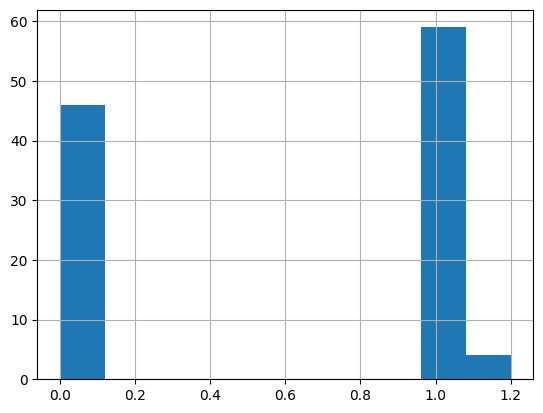

In [164]:
province_gdf["dbsn_availability"] = province_gdf["num_with_dbsn_townhall"] / province_gdf["num_municipalities"]
province_gdf["dbsn_availability"].hist()

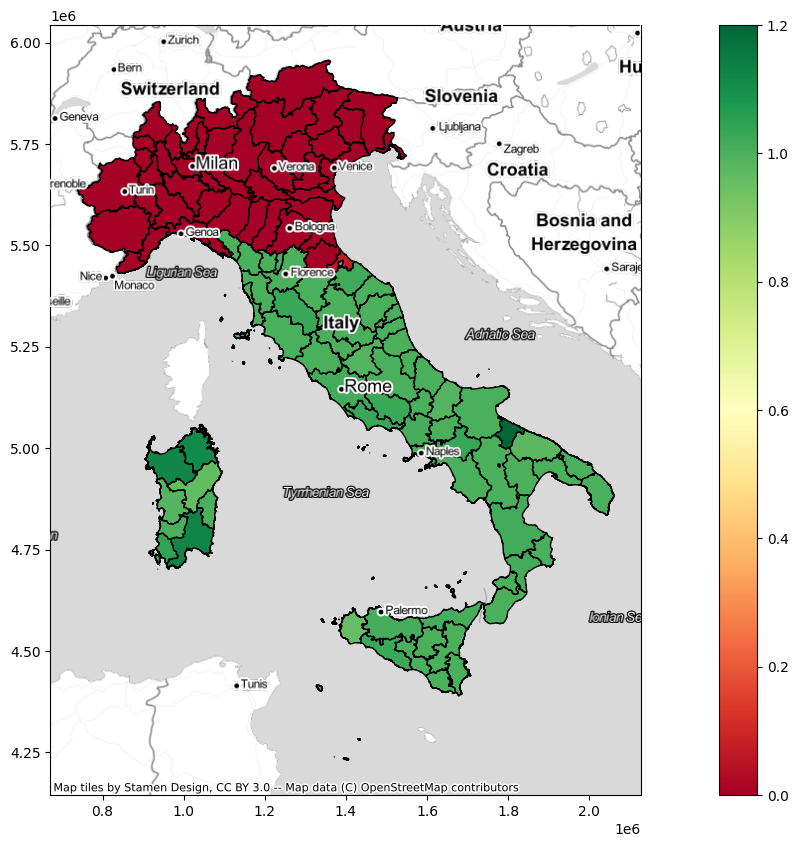

In [165]:
show_map(province_gdf, None, "dbsn_availability", "RdYlGn")

#### Compare existing town halls from OSM and Public Data

In [204]:
dbsn_existing_df = dbsn_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="dbsn",
        rsuffix="town"
    )
dbsn_existing_df.count()

edifc_uso       3557
edifc_ty        3557
edifc_sot       3557
classid         3543
edifc_nome      3556
edifc_stat      3557
edifc_at        3510
scril           3504
meta_ist        3555
edifc_mon       3557
shape_Length    3557
shape_Area      3557
geometry        3557
index_town      3557
id              3557
osm_id          3557
osm_type        3557
osm_url         3557
name            3557
dtype: int64

In [215]:
compare_gdf = merge(
    dbsn_existing_df,
    with_townhall_gdf,
    how="inner",
    left_on="index_town",
    right_on="index_town"
)
compare_gdf.count()

edifc_uso        2970
edifc_ty         2970
edifc_sot        2970
classid          2961
edifc_nome       2969
edifc_stat       2970
edifc_at         2937
scril            2931
meta_ist         2965
edifc_mon        2970
shape_Length     2970
shape_Area       2970
geometry_x       2970
index_town       2970
id               2970
osm_id           2970
osm_type         2970
osm_url          2970
name             2970
id_hall          2970
osm_id_hall      2970
osm_type_hall    2970
osm_url_hall     2970
name_hall        2394
geometry_y       2970
id_town          2970
osm_id_town      2970
osm_type_town    2970
osm_url_town     2970
name_town        2970
dtype: int64

In [219]:
compare_gdf["distance"] = compare_gdf["geometry_x"].to_crs(epsg=3857).distance(compare_gdf["geometry_y"].to_crs(epsg=3857))
compare_gdf["geometry"] = compare_gdf.apply(lambda row: LineString([row['geometry_x'].centroid, row['geometry_y'].centroid]), axis=1).set_crs(epsg=4326)

/home/daniele/.miniconda3/envs/osm/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


array([[<AxesSubplot: title={'center': 'distance'}>]], dtype=object)

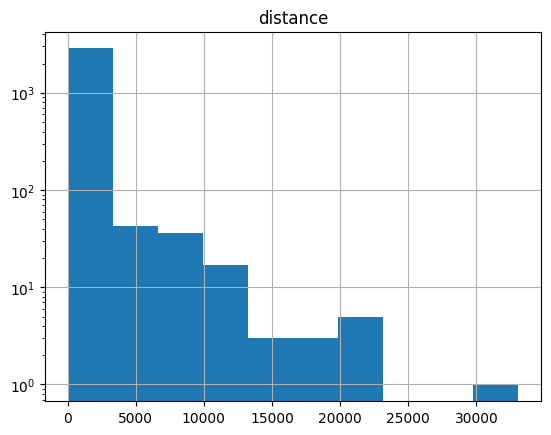

In [220]:
compare_gdf.hist(log=True, column="distance")

In [261]:
conflict_mask=compare_gdf["distance"] > 5000
for word in ["delegazione","circoscrizione","quartiere","municipalità","municipio roma","consorzio"]:
    conflict_mask &= ~(compare_gdf["name_hall"].str.lower().str.contains(word, na=False))
conflict_mask.value_counts()

False    2916
True       54
Name: distance, dtype: int64

In [262]:
dbsn_conflict_gdf = compare_gdf[conflict_mask]
dbsn_conflict_gdf.count()

edifc_uso        54
edifc_ty         54
edifc_sot        54
classid          54
edifc_nome       54
edifc_stat       54
edifc_at         53
scril            53
meta_ist         54
edifc_mon        54
shape_Length     54
shape_Area       54
geometry_x       54
index_town       54
id               54
osm_id           54
osm_type         54
osm_url          54
name             54
id_hall          54
osm_id_hall      54
osm_type_hall    54
osm_url_hall     54
name_hall        35
geometry_y       54
id_town          54
osm_id_town      54
osm_type_town    54
osm_url_town     54
name_town        54
distance         54
geometry         54
dtype: int64

In [263]:
dbsn_conflict_gdf.explore()

In [264]:
dbsn_conflict_gdf.drop(["geometry_x", "geometry_y"], axis=1).to_file(dbsn_conflict_file_path, driver="GeoJSON")

#### Getting missing town halls from Public Data

In [ ]:
dbsn_missing_df = dbsn_gdf.sjoin(
    without_townhall_gdf,
    how="inner",
    predicate="within"
)
dbsn_missing_df.count()

edifc_uso       853
edifc_ty        853
edifc_sot       853
classid         848
edifc_nome      853
edifc_stat      853
edifc_at        836
scril           836
meta_ist        852
edifc_mon       853
shape_Length    853
shape_Area      853
geometry        853
index_right     853
id              853
osm_id          853
osm_type        853
osm_url         853
name            853
dtype: int64

In [ ]:
dbsn_missing_df.head()

,edifc_uso,edifc_ty,edifc_sot,classid,edifc_nome,edifc_stat,edifc_at,scril,meta_ist,edifc_mon,shape_Length,shape_Area,geometry,index_right,id,osm_id,osm_type,osm_url,name
51,0201,01,01,ccebcf60-070d-4e16-a5b5-ddaae2aebab3,Municipio di Castelbellino,03,-29999.0,10k,04,02,112.731642,498.948045,"MULTIPOLYGON Z (((13.14609 43.48797 0.00000, 1...",6471,6472,42476,relation,https://www.openstreetmap.org/relation/42476,Castelbellino
52,0201,01,01,c33b9af6-8977-4c18-b181-6da6f1d4ad4c,Municipio di San Paolo di Jesi,03,-29999.0,10k,04,02,133.693143,783.324298,"MULTIPOLYGON Z (((13.17384 43.45493 0.00000, 1...",6458,6459,42462,relation,https://www.openstreetmap.org/relation/42462,San Paolo di Jesi
61,0201,01,01,E0577A0C-BD70-473B-B93E-2CD1EC108339,Municipio di Cupramontana,03,-9999.0,10k,05,02,110.947122,502.926217,"MULTIPOLYGON Z (((13.11578 43.44564 0.00000, 1...",6448,6449,42451,relation,https://www.openstreetmap.org/relation/42451,Cupramontana
64,0201,01,01,4bd670b4-e7de-4c0d-8412-e504b335a90b,Municipio di Poggio San Marcello,03,-29999.0,10k,04,02,61.302157,230.025172,"MULTIPOLYGON Z (((13.07699 43.51150 0.00000, 1...",6468,6469,49127,relation,https://www.openstreetmap.org/relation/49127,Poggio San Marcello
78,0201,01,01,b065057b-7b88-4dd0-afd0-82bfddbc2314,Municipio di Belvedere Ostrense,03,-29999.0,10k,04,02,80.870315,321.332155,"MULTIPOLYGON Z (((13.16665 43.58040 0.00000, 1...",6462,6463,42496,relation,https://www.openstreetmap.org/relation/42496,Belvedere Ostrense


In [ ]:
dbsn_missing_df.to_file(dbsn_missing_file_path, driver="GeoJSON")

In [ ]:
#%pip install folium matplotlib mapclassify
dbsn_missing_df.explore()